In [1]:
!pip install adversarial-robustness-toolbox
!pip hash
!pip install datasketch



Usage:   pip3 hash [options] <file> ...



In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import VotingClassifier
import random
import hashlib
from sklearn.preprocessing import MinMaxScaler
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
from art.estimators.classification import SklearnClassifier
import time
start_time = time.time()

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Please change the location to where bank-full.csv is saved in google colab. File needs to be run on google colab and panda append is no longer supported on python 3.
df = pd.read_csv('/content/drive/MyDrive/CIS-545_Group2FinalProject/WorkingFiles/bank-full.csv', encoding = 'utf8', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


<Axes: >

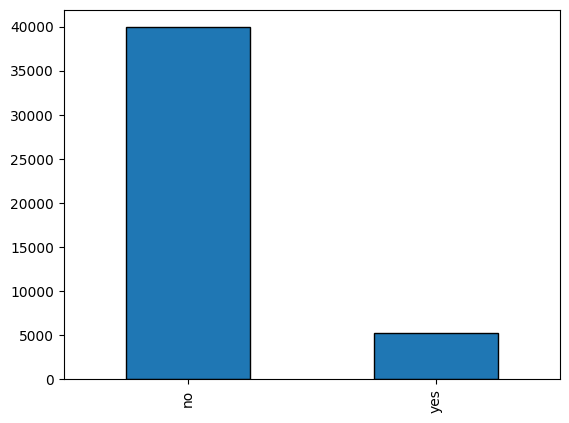

In [4]:
# Plot distribution of values in Marks column using histogram
df['y'].value_counts().plot(kind='bar', edgecolor='black')


In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
#Convert string columns to categorical
df[['job', 'marital','education','default', 'housing', 'loan', 'contact', 'month', 'poutcome','y']] = df[['job', 'marital','education','default', 'housing', 'loan', 'contact', 'month', 'poutcome','y']].astype('category')

In [7]:
#Get dummies for categorical columns
df = pd.concat((df,pd.get_dummies(df[['job', 'marital','education','default', 'housing', 'loan', 'contact', 'month', 'poutcome','y']], drop_first=True)),axis=1)

In [8]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,0,1,0,0,0,0,0,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,0,1,0,0,0,0,0,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,0,0,1,0,0,0,0,0,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,0,1,0,0,0,0,0,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,0,0,0,1,0,0,0,0,1,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,0,0,0,1,0,0,0,0,1,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,0,0,0,1,0,0,0,1,0,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,0,0,0,1,0,0,0,0,1,0


In [9]:
df.dtypes

age                       int64
job                    category
marital                category
education              category
default                category
balance                   int64
housing                category
loan                   category
contact                category
day                       int64
month                  category
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
poutcome               category
y                      category
job_blue-collar           uint8
job_entrepreneur          uint8
job_housemaid             uint8
job_management            uint8
job_retired               uint8
job_self-employed         uint8
job_services              uint8
job_student               uint8
job_technician            uint8
job_unemployed            uint8
job_unknown               uint8
marital_married           uint8
marital_single            uint8
education_secondary       uint8
educatio

In [10]:
#X and y dataframes
X = df.drop(columns=['job', 'marital','education','default', 'housing', 'loan', 'contact', 'month', 'poutcome','y','y_yes']) #drop categorical columns
y = df['y_yes']

In [11]:
# Min-Max Normalization
df_cont = X.copy()
df_cont.drop(df_cont.iloc[:, 7:], inplace=True, axis=1)

df_disc = X.copy()
df_disc.drop(df_disc.iloc[:, :7], inplace=True, axis=1)

df_cont = (df_cont-df_cont.min())/(df_cont.max()-df_cont.min())
X_scaled= pd.concat((df_cont, df_disc), 1)

print("Scaled Dataset Using Pandas")
X_scaled.head(15)

Scaled Dataset Using Pandas


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.092259,0.133333,0.053070,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.337662,0.073067,0.133333,0.030704,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.194805,0.072822,0.133333,0.015453,0.0,0.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0.376623,0.086476,0.133333,0.018707,0.0,0.0,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.194805,0.072812,0.133333,0.040260,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,0.220779,0.074901,0.133333,0.028264,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,0.129870,0.076862,0.133333,0.044124,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,0.311688,0.072822,0.133333,0.077267,0.0,0.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,0.519481,0.073902,0.133333,0.010167,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,0.324675,0.078187,0.133333,0.011183,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [12]:
#add constant to predictor variables
X_scaled = sm.add_constant(X_scaled)

In [13]:
#Create hashing column for each row in X
X_scaled['sha1_hash'] = X_scaled.apply(lambda x: hashlib.sha1(str(tuple(x)).encode('utf-8')).hexdigest(), axis=1)


In [14]:
# split data into training and test sets: scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X_scaled.iloc[:, 0:43], y, test_size=0.20, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36168, 43)
(36168,)
(9043, 43)
(9043,)


In [15]:
# Construct a logistic regression model
def logistic_regression(x,y):
  logistic_model = LogisticRegression(class_weight='balanced', solver='newton-cg', penalty='l2', max_iter=1000, random_state=42)
  logistic_model = logistic_model.fit(x,y)

  coeffs = logistic_model.coef_[0,:]     # Coefficients as an array for np.dot

  return logistic_model, coeffs

# Prediction function
def prediction(x,coeffs):
    y_pred = np.dot(x,coeffs)            # Prediction for each X
    p_pred = 1/(1+np.exp(-y_pred))             # Probability of Y = 1

    return y_pred,p_pred

# Evaluation function
def evaluation(y,p_pred):
  from sklearn import metrics
  fpr, tpr, thresholds = metrics.roc_curve(y, p_pred);
  #plt.plot([0, 1], [0, 1], 'k--');
  #plt.plot(fpr, tpr);
  #plt.xlabel('False Positive Rate = 1 - Specificity')
  #plt.ylabel('True Positive Rate = Sensitivity')

  #Summary of results
  threshold = 0.75                                                # Default threshold = 0.5
  #threshold = np.sum(1*(y==1))/len(y)                            # Recommended threshold = n_1/n
  Y_pred = pd.DataFrame() # Declare a panda
  Y_pred['Class_true'] = y
  Y_pred['Class_pred'] = 1*(p_pred>threshold)
  Y_pred['P_pred'] = p_pred
  Y_pred['TP'] = 1*((Y_pred['Class_true']==1) & (Y_pred['Class_pred'] == 1))
  Y_pred['FP'] = 1*((Y_pred['Class_true']==0) & (Y_pred['Class_pred'] == 1))
  Y_pred['TN'] = 1*((Y_pred['Class_true']==0) & (Y_pred['Class_pred'] == 0))
  Y_pred['FN'] = 1*((Y_pred['Class_true']==1) & (Y_pred['Class_pred'] == 0))
  Y_pred



  #print('\n#################################')
  #print('Calculated outputs given the threshold ', threshold)
  #print('#################################')

  #print('Confusion matrix\n', metrics.confusion_matrix(Y_pred['Class_true'],Y_pred['Class_pred']))
  #print('\nNormalized Confusion Matrix\n', metrics.confusion_matrix(Y_pred['Class_true'],Y_pred['Class_pred'])/np.shape(Y_pred)[0])

  #print('\n#################################')
  #print('Python quick outputs')
  print('#################################')
  print('Accuracy = ', metrics.accuracy_score(Y_pred['Class_true'],Y_pred['Class_pred']))
  #print('Precision = ', metrics.precision_score(Y_pred['Class_true'],Y_pred['Class_pred']))
  #print('Recall = ', metrics.recall_score(Y_pred['Class_true'],Y_pred['Class_pred']))
  #print('F1 = ', metrics.f1_score(Y_pred['Class_true'],Y_pred['Class_pred']))
  #print('\nThe Area Under the ROC Curve is : ', metrics.auc(fpr,tpr))
  print('#################################')
  return Y_pred


In [16]:
#Get Logistic Model
model,coeffs = logistic_regression(X_train,y_train)
#model.summary()

In [17]:
#How good is the model with train data?
y_pred,p_pred = prediction(X_train,coeffs)
Y_pred = evaluation(y_train,p_pred)

#################################
Accuracy =  0.8706591462065915
#################################


In [18]:
from sklearn import metrics
#Test Results
y_pred,p_pred = prediction(X_test,coeffs)
Y_pred = evaluation(y_test,p_pred)
u_model_acc = metrics.accuracy_score(Y_pred['Class_true'],Y_pred['Class_pred'])

#################################
Accuracy =  0.8690699988941722
#################################


In [19]:
# Create a training data frame to split in n disjoint subsets
df_train = X_train.copy()
df_train['y_yes'] = y_train.copy()
df_train


,const,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
3344,1.0,0.298701,0.080511,0.466667,0.014640,0.000000,0.000000,0.000000,1,0,...,0,0,1,0,0,0,0,0,1,0
17965,1.0,0.402597,0.085650,0.966667,0.054697,0.016129,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0
18299,1.0,0.311688,0.107684,1.000000,0.026434,0.048387,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0
10221,1.0,0.246753,0.071723,0.333333,0.076251,0.161290,0.000000,0.000000,0,0,...,1,0,0,0,0,0,0,0,1,0
32192,1.0,0.493506,0.104561,0.466667,0.053680,0.016129,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.0,0.337662,0.082418,0.566667,0.425580,0.000000,0.000000,0.000000,0,0,...,1,0,0,0,0,0,0,0,1,1
44732,1.0,0.064935,0.077415,0.233333,0.042700,0.000000,0.106651,0.003636,0,0,...,0,0,0,0,0,1,0,0,0,0
38158,1.0,0.207792,0.084760,0.466667,0.048597,0.000000,0.000000,0.000000,0,0,...,0,0,1,0,0,0,0,0,1,0
860,1.0,0.194805,0.074301,0.200000,0.022570,0.000000,0.000000,0.000000,0,0,...,0,0,1,0,0,0,0,0,1,0


In [20]:
#split in n disjoint subsets
n = 6
size = int((len(df_train) - len(df_train)%n)/n) #removing the remainder is discarding some data
#print(len(df_train))
sample_ = {}
df_holder = df_train

for i in range(1, n + 1):
    sample_[i] = df_holder.sample(size)
    df_holder = df_holder.drop(sample_[i].index)


In [21]:
#Build Models for ensemble
X_sample_={}
y_sample_={}
y_pred_={}
p_pred_={}
Y_pred_={}
model_={}
coeffs_={}

from sklearn import metrics

#X and y dataframes
for i in range(1,n+1,1):
  print('F',i)
  X_sample_[i] = sample_[i].drop(columns=['y_yes']) #drop y column
  y_sample_[i] = sample_[i]['y_yes']
  #print(X_sample_[i])
  #Get Logistic Model and Summary
  model_[i],coeffs_[i] = logistic_regression(X_sample_[i],y_sample_[i])
  #How good is the model with train data?
  y_pred_[i],p_pred_[i] = prediction(X_sample_[i],coeffs)
  Y_pred_[i] = evaluation(y_sample_[i],p_pred_[i])

p_model_acc = metrics.accuracy_score(Y_pred_[i]['Class_true'],Y_pred_[i]['Class_pred'])


F 1
#################################
Accuracy =  0.8735899137358991
#################################
F 2
#################################
Accuracy =  0.8769077637690776
#################################
F 3
#################################
Accuracy =  0.8659588586595885
#################################
F 4
#################################
Accuracy =  0.8674518911745189
#################################
F 5
#################################
Accuracy =  0.871765096217651
#################################
F 6
#################################
Accuracy =  0.8682813536828136
#################################


In [22]:
#Formating the models for ensembel input
model_list = list(model_.values())
indice_list = list(np.array(list(model_.keys()), dtype=str))
combined_original=[]
for i in range (len(model_)):
  combined_original.append((indice_list[i],model_list[i]))

In [23]:
#Running ensemble input
ensemble_original = VotingClassifier(estimators=combined_original, voting='soft')
ensemble_original.fit(X_train,y_train)

VotingClassifier(estimators=[('1',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('2',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('3',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('4',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('5',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('6',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg'))],
                 voting='soft')

In [24]:
#Accuracy of Ensemble
y_pred_original = ensemble_original.predict(X_train)
p_pred_original = ensemble_original.predict_proba(X_train)[:,1]
Y_pred_original = evaluation(y_train,p_pred_original)

#################################
Accuracy =  0.8961236452112364
#################################


In [25]:
#Create sets of ensembles ((model1+model2+model3...,modeln), (model1+model3,...,modeln),...))

found = False

ensemble_={}
ensemblefit_={}

X_train_minus_={}
y_train_minus_={}

# Iterate over each model
for i in range(1,n+1,1):
  model_copy = model_.copy()
  X_sample_copy = X_sample_[i].iloc[:, 0:43].copy()
  y_sample_copy = y_sample_[i].copy()
  model_copy.pop(i)

  # Remove X_sample_copy out of X_train
  X_train_minus_[i] = pd.concat([X_train, X_sample_copy]).drop_duplicates(keep=False)

  # Remove y_sample_copy out of y_train
  y_train_minus_[i] = y_train.drop(list(y_sample_copy.index))

  model_list = list(model_copy.values())
  indice_list = list(np.array(list(model_copy.keys()), dtype=str))
  combined=[]
  for j in range (len(model_copy)):
      combined.append((indice_list[j],model_list[j]))


  #Running ensemble input
  ensemble_[i] = VotingClassifier(estimators=combined, voting='soft', n_jobs=-1)
  ensemble_[i].fit(X_train_minus_[i],y_train_minus_[i])



In [26]:
#Adding last set which includes all models.
ensemble_[n+1] = VotingClassifier(estimators=combined_original, voting='soft')
ensemble_[n+1].fit(X_train,y_train)

VotingClassifier(estimators=[('1',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('2',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('3',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('4',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('5',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('6',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg'))],
                 voting='soft')

In [27]:
ensemble_[1]

VotingClassifier(estimators=[('2',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('3',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('4',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('5',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg')),
                             ('6',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg'))],
                 n_jobs=-1, voting='soft')

In [28]:
#Hashing of samples X_samples:

for i in range(1,n+1,1):
  X_sample_[i]['sha1_hash'] = X_sample_[i].apply(lambda x: hashlib.sha1(str(tuple(x)).encode('utf-8')).hexdigest(), axis=1)

In [29]:
#EXACT SIGNATURE MATCHING EXCLUSION
def ExactOracle(user_input,ensemble_,X_sample_):

  found = False

  # Iterate over each model
  for i in range(1,n+1,1):
        if len(X_sample_[i].loc[X_sample_[i]['sha1_hash'] == user_input])==1:

            idx = X_sample_[i].loc[X_sample_[i]['sha1_hash'] == user_input].index.item()

            return i, idx # Exit the loop if a match is found

  idx = X_scaled.loc[X_scaled['sha1_hash'] == user_input].index.item()
  return n+1, idx

In [30]:
# Attacker has the entire dataset but they do not know what data points are part of the training set so they split data into training and test sets
# to try to infer.
X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_scaled.iloc[:,0:43], y, test_size=0.15, random_state=23)

print(X_attack_train.shape)
print(y_attack_train.shape)
print(X_attack_test.shape)
print(y_attack_test.shape)

(38429, 43)
(38429,)
(6782, 43)
(6782,)


In [31]:
# Running Attack on base model (logistic regression)
classifier = model

#Train the classifier
classifier.fit(X_train.to_numpy(), y_train.to_numpy())

#Convert the scikit-learn classifier to an ART-compatible classifier
estimator = SklearnClassifier(model=classifier)

# Create the MembershipInferenceBlackBoxRuleBased attack
attack = MembershipInferenceBlackBoxRuleBased(estimator)

In [32]:
# infer attacked feature
inferred_train = attack.infer(X_attack_train.to_numpy(), y_attack_train.to_numpy())
inferred_test = attack.infer(X_attack_test.to_numpy(), y_attack_test.to_numpy())

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
#print(f"Members Accuracy: {train_acc:.4f}")
#print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Attack Accuracy 0.7427


In [33]:
# Running Attack on ensemble model (logistic regression on disjoint datasets)
classifier = ensemble_original

#Train the classifier
classifier.fit(X_train.to_numpy(), y_train.to_numpy())

#Convert the scikit-learn classifier to an ART-compatible classifier
estimator = SklearnClassifier(model=classifier)

# Create the MembershipInferenceBlackBoxRuleBased attack
attack = MembershipInferenceBlackBoxRuleBased(estimator)

In [34]:
# infer attacked feature
inferred_train = attack.infer(X_attack_train.to_numpy(), y_attack_train.to_numpy())
inferred_test = attack.infer(X_attack_test.to_numpy(), y_attack_test.to_numpy())

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
u_acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
#print(f"Members Accuracy: {train_acc:.4f}")
#print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {u_acc:.4f}")

Attack Accuracy 0.7427


In [35]:
#now for implementing the oracle we find out which model and training dataset the attack belongs to.

federated_data1 = []

input = X_attack_train

for i in range (0,len(input)):
  user_input = input.iloc[[i]].copy()
  user_input['sha1_hash'] = user_input.apply(lambda x: hashlib.sha1(str(tuple(x)).encode('utf-8')).hexdigest(), axis=1)
  user_input = user_input['sha1_hash'].item()

  federated_data1.append (ExactOracle(user_input,ensemble_,X_sample_))

federated_data2 = []

input = X_attack_test

for i in range (0,len(input)):
  user_input = input.iloc[[i]].copy()
  user_input['sha1_hash'] = user_input.apply(lambda x: hashlib.sha1(str(tuple(x)).encode('utf-8')).hexdigest(), axis=1)
  user_input = user_input['sha1_hash'].item()

  federated_data2.append (ExactOracle(user_input,ensemble_,X_sample_))




In [36]:
#create subsets of attack data corresponding to each model

X_attack_train_= {}
X_attack_test_= {}

y_attack_train_={}
y_attack_test_={}

for i in range(1, len(ensemble_)+1):
  X_attack_train_[i] = pd.DataFrame(columns=X_attack_train.columns)
  X_attack_test_[i] = pd.DataFrame(columns=X_attack_test.columns)

  y_attack_train_[i] = pd.Series()
  y_attack_test_[i] = pd.Series()

for modelnumber, idx in federated_data1:
  X_attack_train_[modelnumber] = X_attack_train_[modelnumber].append(X_attack_train.loc[[idx]])
  y_attack_train_[modelnumber] = y_attack_train_[modelnumber].append(y_attack_train.loc[[idx]])

for modelnumber, idx in federated_data2:
  X_attack_test_[modelnumber] = X_attack_test_[modelnumber].append(X_attack_test.loc[[idx]])
  y_attack_test_[modelnumber] = y_attack_test_[modelnumber].append(y_attack_test.loc[[idx]])



In [37]:
#remove attack data from base file to confuse attack

X_train_minus_attack_={}
y_train_minus_attack_={}

X_test_minus_attack_={}
y_test_minus_attack_={}

for i in range(1,n+1,1):

  # Remove X_sample_copy_a out of X_train
  X_train_minus_attack_[i] = pd.concat([X_scaled.iloc[:,0:43], X_attack_train_[i]]).drop_duplicates(keep=False)

  # Remove y_sample_copy_a out of y_train
  y_train_minus_attack_[i] = y.drop(list(y_attack_train_[i].index))


  # Remove X_sample_copy_a out of X_train
  X_test_minus_attack_[i] = pd.concat([X_scaled.iloc[:,0:43], X_attack_test_[i]]).drop_duplicates(keep=False)

  # Remove y_sample_copy_a out of y_train
  y_test_minus_attack_[i] = y.drop(list(y_attack_test_[i].index))


In [38]:
#Last set added
X_train_minus_attack_[n+1] = pd.concat([X_scaled.iloc[:,0:43], X_attack_train_[n+1]]).drop_duplicates(keep=False)
X_test_minus_attack_[n+1] = pd.concat([X_scaled.iloc[:,0:43], X_attack_test_[n+1]]).drop_duplicates(keep=False)
y_train_minus_attack_[n+1] = y.drop(list(y_attack_train_[7].index))
y_test_minus_attack_[n+1] = y.drop(list(y_attack_test_[7].index))

In [39]:
#Run attack on models trained on disjointed datasets

from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased
from art.estimators.classification import SklearnClassifier
#model
#ensemble_original

for i in range(1, len(ensemble_)+1):
  # Step 1: Choose a classifier
  classifier = ensemble_[i]

  if i != len(ensemble_):
    # Step 2: Train the classifier
    classifier.fit(X_train_minus_[i].to_numpy(), y_train_minus_[i].to_numpy())
  else:
    classifier.fit(X_test.to_numpy(), y_test.to_numpy())

  # Step 3: Convert the scikit-learn classifier to an ART-compatible classifier
  estimator = SklearnClassifier(model=classifier)

  # Create the MembershipInferenceBlackBoxRuleBased attack
  attack = MembershipInferenceBlackBoxRuleBased(estimator)

  # Now you can proceed with the attack using the specified classifier
  import numpy as np
  from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

  # infer attacked feature
  inferred_train = attack.infer(X_train_minus_attack_[i].to_numpy(), y_train_minus_attack_[i].to_numpy())
  inferred_test = attack.infer(X_test_minus_attack_[i].to_numpy(), y_test_minus_attack_[i].to_numpy())

  # check accuracy
  train_acc = np.sum(inferred_train) / len(inferred_train)
  test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
  p_acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
  #print(f"Members Accuracy: {train_acc:.4f}")
  #print(f"Non Members Accuracy {test_acc:.4f}")
  print(f"Protected Attack Accuracy {p_acc:.4f}")

Protected Attack Accuracy 0.4825
Protected Attack Accuracy 0.4826
Protected Attack Accuracy 0.4829
Protected Attack Accuracy 0.4831
Protected Attack Accuracy 0.4823
Protected Attack Accuracy 0.4825
Protected Attack Accuracy 0.4733


In [40]:
#end of program
print("--- %s seconds ---" % (time.time() - start_time))

--- 625.7707874774933 seconds ---


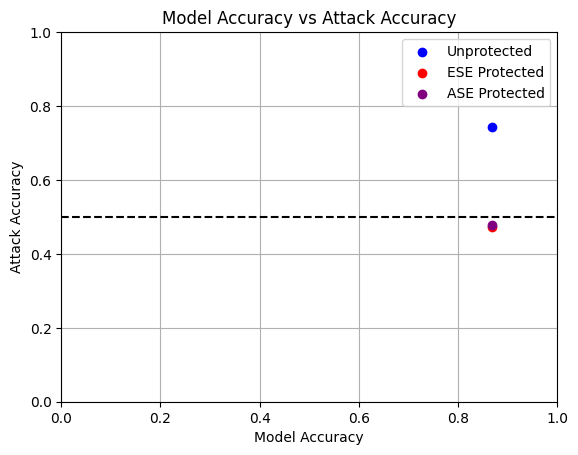

In [41]:
#Plot for report

# Scatter plot for unprotected group
plt.scatter(u_model_acc, u_acc, label='Unprotected', color='blue')

# Scatter plot for protected group
plt.scatter(p_model_acc, p_acc, label='ESE Protected', color='red')

# Scatter plot for protected group
plt.scatter(p_model_acc, 0.477, label='ASE Protected', color='purple')

# Set plot labels and title
plt.xlabel('Model Accuracy')
plt.ylabel('Attack Accuracy')
plt.title('Model Accuracy vs Attack Accuracy')
plt.legend()
plt.grid(True)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Draw a horizontal line at y = 0.5
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold (y = 0.5)')

# Show the plot
plt.show()